In [1]:
library(data.table)
library(cowplot)
library(Matrix)
library(BuenColors)
library(umap)
library(SummarizedExperiment)

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: MASS
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:Matrix’:

    colMeans, colSums, rowMeans, rowSums, which

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, 

In [2]:
run_pca <- function(mat,num_pcs=50,scale=FALSE,center=FALSE){
    set.seed(2019) 
    SVD = irlba(mat, num_pcs, num_pcs,scale=scale,center=center)
    sk_diag = matrix(0, nrow=num_pcs, ncol=num_pcs)
    diag(sk_diag) = SVD$d
    SVD_vd = t(sk_diag %*% t(SVD$v))
    return(t(SVD_vd))
}

elbow_plot <- function(mat,num_pcs=50,scale=FALSE,center=FALSE,title='',width=3,height=3){
    set.seed(2019) 
    mat = data.matrix(mat)
    SVD = irlba(mat, num_pcs, num_pcs,scale=scale,center=center)
    options(repr.plot.width=width, repr.plot.height=height)
    df_plot = data.frame(PC=1:num_pcs, SD=SVD$d);
#     print(SVD$d[1:num_pcs])
    p <- ggplot(df_plot, aes(x = PC, y = SD)) +
      geom_point(col="#cd5c5c",size = 1) + 
      ggtitle(title)
    return(p)
}

run_umap <- function(fm_mat){
    umap_object = umap(t(fm_mat),random_state = 2019)
    df_umap = umap_object$layout
    return(df_umap)
}


plot_umap <- function(df_umap,labels,title='UMAP',colormap=colormap){
    set.seed(2019) 
    df_umap = data.frame(cbind(df_umap,labels),stringsAsFactors = FALSE)
    colnames(df_umap) = c('umap1','umap2','celltype')
    df_umap$umap1 = as.numeric(df_umap$umap1)
    df_umap$umap2 = as.numeric(df_umap$umap2)
    options(repr.plot.width=4, repr.plot.height=4)
    p <- ggplot(shuf(df_umap), aes(x = umap1, y = umap2, color = celltype)) +
      geom_point(size = 1) + scale_color_manual(values = colormap) +
      ggtitle(title)
    return(p)
}

run_SCRAT <- function(se,genome='hg19',adjustlen = TRUE, log2transform = TRUE){
    genome = 'hg19'
    Motifflank = 100
    allres <- NULL
    scrat_counts = assays(se)$counts
    gr_peaks <- rowRanges(se)
    datapath <- system.file("extdata", package = paste0("SCRATdata", 
        genome))
    print("Processing MOTIF_JASPAR features")
    
    load(paste0(datapath, "/gr/jaspar1.rda"))
    gr <- flank(gr, as.numeric(Motifflank), both = T)
    # tmp <- sapply(bamdata, function(i) countOverlaps(gr, 
    #     i))
    # tmp <- sweep(tmp, 2, bamsummary, "/") * 10000
    ov_peaks = findOverlaps(gr, gr_peaks)
    m <- Matrix::sparseMatrix(i = c(queryHits(ov_peaks), length(gr)),
                              j = c(subjectHits(ov_peaks), length(gr_peaks)))
    mat_motif = m %*% scrat_counts 
    tmp <- sweep(mat_motif, 2, Matrix::colSums(scrat_counts), "/") * 10000

    if (log2transform) {
        tmp <- log2(tmp + 1)
    }
    if (adjustlen) {
        grrange <- sapply(gr, function(i) sum(end(i) - start(i) + 
            1))
        tmp <- sweep(tmp, 1, grrange, "/") * 1e+06
    }
    tmp <- tmp[Matrix::rowSums(tmp) > 0, , drop = F]
    allres <- rbind(allres, tmp)

    load(paste0(datapath, "/gr/jaspar2.rda"))
    gr <- flank(gr, as.numeric(Motifflank), both = T)
    # tmp <- sapply(bamdata, function(i) countOverlaps(gr, 
    #     i))
    # tmp <- sweep(tmp, 2, bamsummary, "/") * 10000

    ov_peaks = findOverlaps(gr, gr_peaks)
    m <- Matrix::sparseMatrix(i = c(queryHits(ov_peaks), length(gr)),
                              j = c(subjectHits(ov_peaks), length(gr_peaks)))
    mat_motif = m %*% scrat_counts 

    tmp <- sweep(mat_motif, 2, Matrix::colSums(scrat_counts), "/") * 10000
    if (log2transform) {
        tmp <- log2(tmp + 1)
    }
    if (adjustlen) {
        grrange <- sapply(gr, function(i) sum(end(i) - start(i) + 
            1))
        tmp <- sweep(tmp, 1, grrange, "/") * 1e+06
    }
    tmp <- tmp[Matrix::rowSums(tmp) > 0, , drop = F]
    allres <- rbind(allres, tmp)     
    fm_SCRAT = as.matrix(allres)
    return(fm_SCRAT)
}

#### Buenrostro2018

In [3]:
metadata <- read.table('../Buenrostro_2018/input/metadata.tsv',
                         header = TRUE,
                         stringsAsFactors=FALSE,quote="",row.names=1)

In [4]:
fm_SCRAT_Buenrostro2018_no = readRDS('./FM_SCRAT_buenrostro2018_motifs.rds')

In [5]:
fm_SCRAT_Buenrostro2018_log2transform = readRDS('./FM_SCRAT_buenrostro2018_motifs_log2transform.rds')

In [6]:
fm_SCRAT_Buenrostro2018_adjustlen = readRDS('./FM_SCRAT_buenrostro2018_motifs_adjustlen.rds')

In [7]:
df_umap_SCRAT_Buenrostro2018_no<- run_umap(fm_SCRAT_Buenrostro2018_no)

In [8]:
df_umap_SCRAT_Buenrostro2018_adjustlen<- run_umap(fm_SCRAT_Buenrostro2018_adjustlen)

In [9]:
df_umap_SCRAT_Buenrostro2018_log2transform<- run_umap(fm_SCRAT_Buenrostro2018_log2transform)

In [10]:
labels = metadata$label
colormap = c(jdb_color_maps, "UNK" = "#333333" )

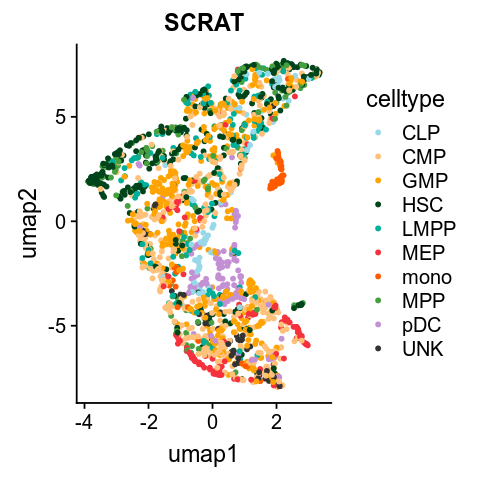

In [11]:
p_SCRAT_Buenrostro2018_no <- plot_umap(df_umap_SCRAT_Buenrostro2018_no,labels = labels,colormap = colormap,
                                       title='SCRAT')
p_SCRAT_Buenrostro2018_no

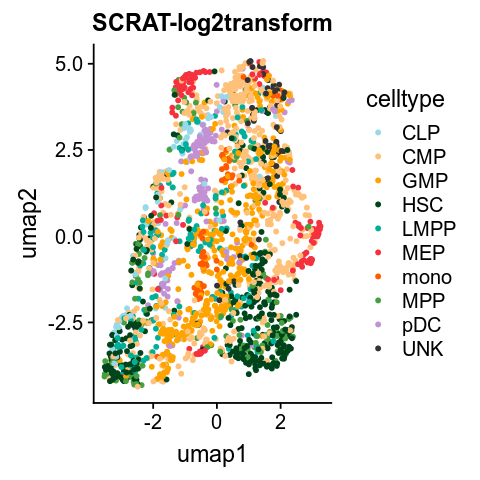

In [12]:
p_SCRAT_Buenrostro2018_log2transform <- plot_umap(df_umap_SCRAT_Buenrostro2018_log2transform,labels = labels,colormap = colormap,
                                       title='SCRAT-log2transform')
p_SCRAT_Buenrostro2018_log2transform

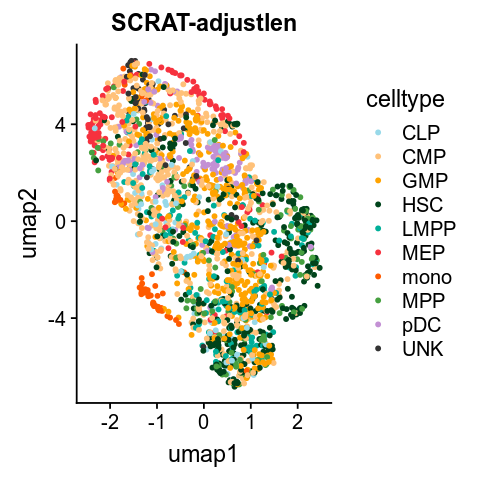

In [13]:
p_SCRAT_Buenrostro2018_adjustlen <- plot_umap(df_umap_SCRAT_Buenrostro2018_adjustlen,labels = labels,colormap = colormap,
                                       title='SCRAT-adjustlen')
p_SCRAT_Buenrostro2018_adjustlen

In [ ]:
# options(repr.plot.width=4*2, repr.plot.height=4*1)
# p_group = cowplot::plot_grid(p_SCRAT,p_SCRAT2, labels = "AUTO",ncol = 2)

In [ ]:
# options(repr.plot.width=4*2, repr.plot.height=4*1)
# cowplot::ggsave(p_group,filename = 'SCRAT_norm_VS_nonorm.pdf', width = 4*2, height = 4*1)

#### Bone Marrow

In [14]:
se_BM = readRDS('../BoneMarrow_noisy_p2/output/se.rds')

In [15]:
se_BM

class: RangedSummarizedExperiment 
dim: 80000 1200 
metadata(0):
assays(1): counts
rownames(80000): chr1_30528_31028 chr1_97671_98171 ...
  chrX_154841997_154842497 chrX_154862080_154862580
rowData names(0):
colnames(1200): CD4_1 CD4_2 ... NK_1199 NK_1200
colData names(1): label

In [16]:
labels = se_BM@colData$label
colormap = jdb_color_maps

In [17]:
fm_SCRAT_BM_no = run_SCRAT(se_BM,adjustlen = FALSE, log2transform = FALSE)
df_umap_SCRAT_BM_no<- run_umap(fm_SCRAT_BM_no)

[1] "Processing MOTIF_JASPAR features"


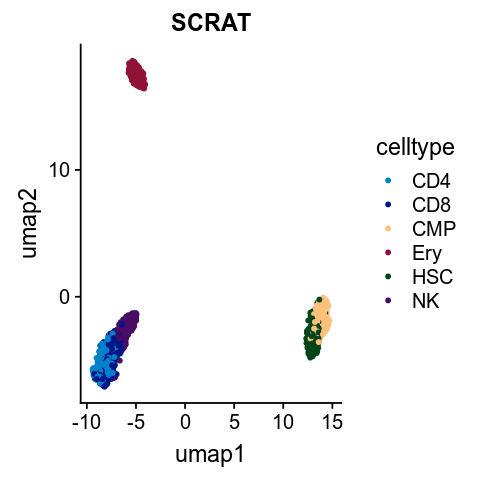

In [18]:
p_SCRAT_BM_no <- plot_umap(df_umap_SCRAT_BM_no,labels = labels,colormap = colormap,title='SCRAT')
p_SCRAT_BM_no

In [19]:
fm_SCRAT_BM_log2transform = run_SCRAT(se_BM,adjustlen = FALSE, log2transform = TRUE)
df_umap_SCRAT_BM_log2transform<- run_umap(fm_SCRAT_BM_log2transform)

[1] "Processing MOTIF_JASPAR features"


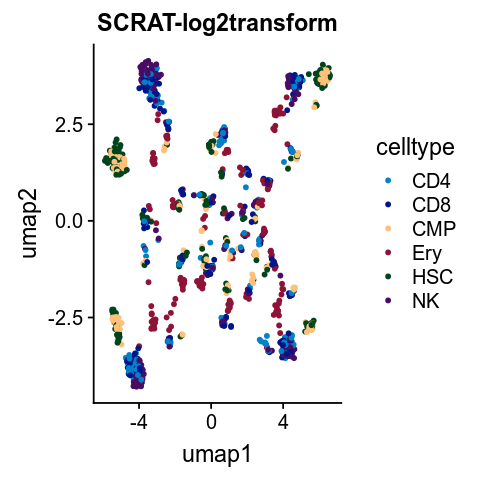

In [20]:
p_SCRAT_BM_log2transform <- plot_umap(df_umap_SCRAT_BM_log2transform,labels = labels,colormap = colormap,title='SCRAT-log2transform')
p_SCRAT_BM_log2transform

In [21]:
fm_SCRAT_BM_adjustlen = run_SCRAT(se_BM,adjustlen = TRUE, log2transform = FALSE)
df_umap_SCRAT_BM_adjustlen<- run_umap(fm_SCRAT_BM_adjustlen)

[1] "Processing MOTIF_JASPAR features"


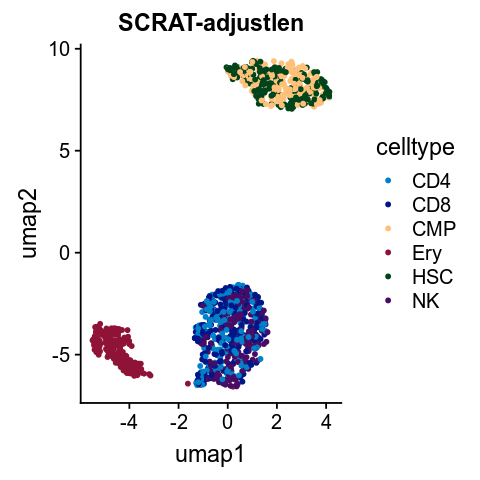

In [22]:
p_SCRAT_BM_adjustlen <- plot_umap(df_umap_SCRAT_BM_adjustlen,labels = labels,colormap = colormap,title='SCRAT-adjustlen')
p_SCRAT_BM_adjustlen

#### Erythropoiesis

In [23]:
se_Ery = readRDS('../Erythropoiesis_noisy_p2/output/se.rds')

In [24]:
se_Ery

class: RangedSummarizedExperiment 
dim: 80000 1200 
metadata(0):
assays(1): counts
rownames(80000): chr1_10371_10621 chr1_115582_115832 ...
  chrX_154842448_154842698 chrX_154862148_154862398
rowData names(0):
colnames(1200): CMP_1 CMP_2 ... P8_1199 P8_1200
colData names(1): label

In [25]:
labels = se_Ery@colData$label

eryth_color_maps <- c("P1" = "#3b82ae", "P2" = "#547294", "P3" = "#6d617a", "P4" = "#865160", "P5" = "#9f4046", "P6" = "#b8302c", "P7" = "#d11f12", "P8" = "#de1705")
all_color_maps <- c(ejc_color_maps[c("HSC", "MPP", "CMP")], "MEP" = "#FF81AF" ,eryth_color_maps)
colormap = all_color_maps

In [26]:
fm_SCRAT_Ery_no = run_SCRAT(se_Ery,adjustlen = FALSE, log2transform = FALSE)
df_umap_SCRAT_Ery_no<- run_umap(fm_SCRAT_Ery_no)

[1] "Processing MOTIF_JASPAR features"


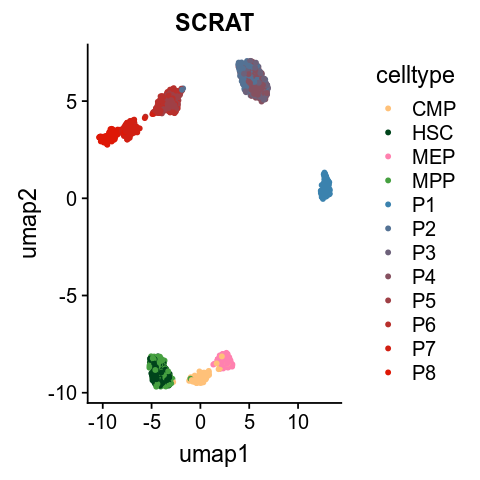

In [27]:
p_SCRAT_Ery_no <- plot_umap(df_umap_SCRAT_Ery_no,labels = labels,colormap = colormap,title='SCRAT')
p_SCRAT_Ery_no

In [28]:
fm_SCRAT_Ery_log2transform = run_SCRAT(se_Ery,adjustlen = FALSE, log2transform = TRUE)
df_umap_SCRAT_Ery_log2transform<- run_umap(fm_SCRAT_Ery_log2transform)

[1] "Processing MOTIF_JASPAR features"


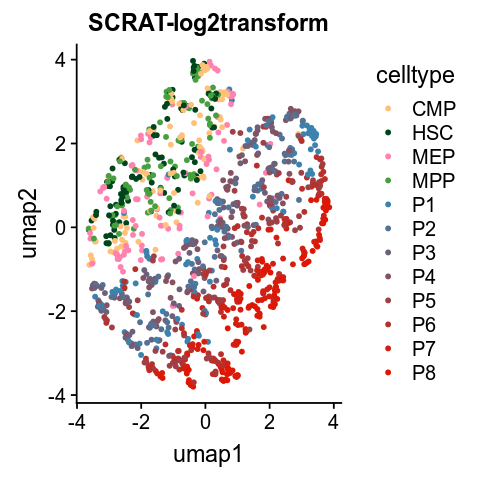

In [29]:
p_SCRAT_Ery_log2transform <- plot_umap(df_umap_SCRAT_Ery_log2transform,labels = labels,colormap = colormap,title='SCRAT-log2transform')
p_SCRAT_Ery_log2transform

In [30]:
fm_SCRAT_Ery_adjustlen = run_SCRAT(se_Ery,adjustlen = TRUE, log2transform = FALSE)
df_umap_SCRAT_Ery_adjustlen<- run_umap(fm_SCRAT_Ery_adjustlen)

[1] "Processing MOTIF_JASPAR features"


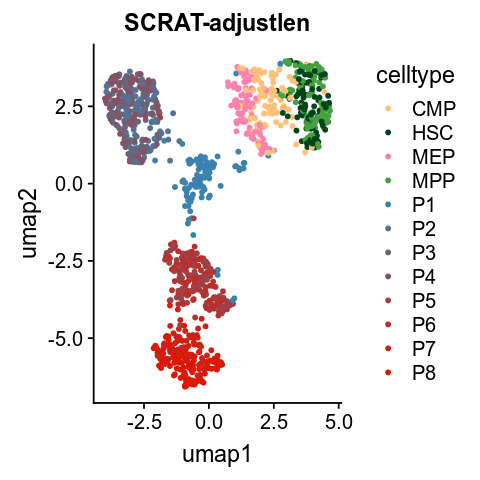

In [31]:
p_SCRAT_Ery_adjustlen <- plot_umap(df_umap_SCRAT_Ery_adjustlen,labels = labels,colormap = colormap,title='SCRAT-adjustlen')
p_SCRAT_Ery_adjustlen

#### Assemble plots

In [2]:
load('test_SCRAT_parameters.RData')

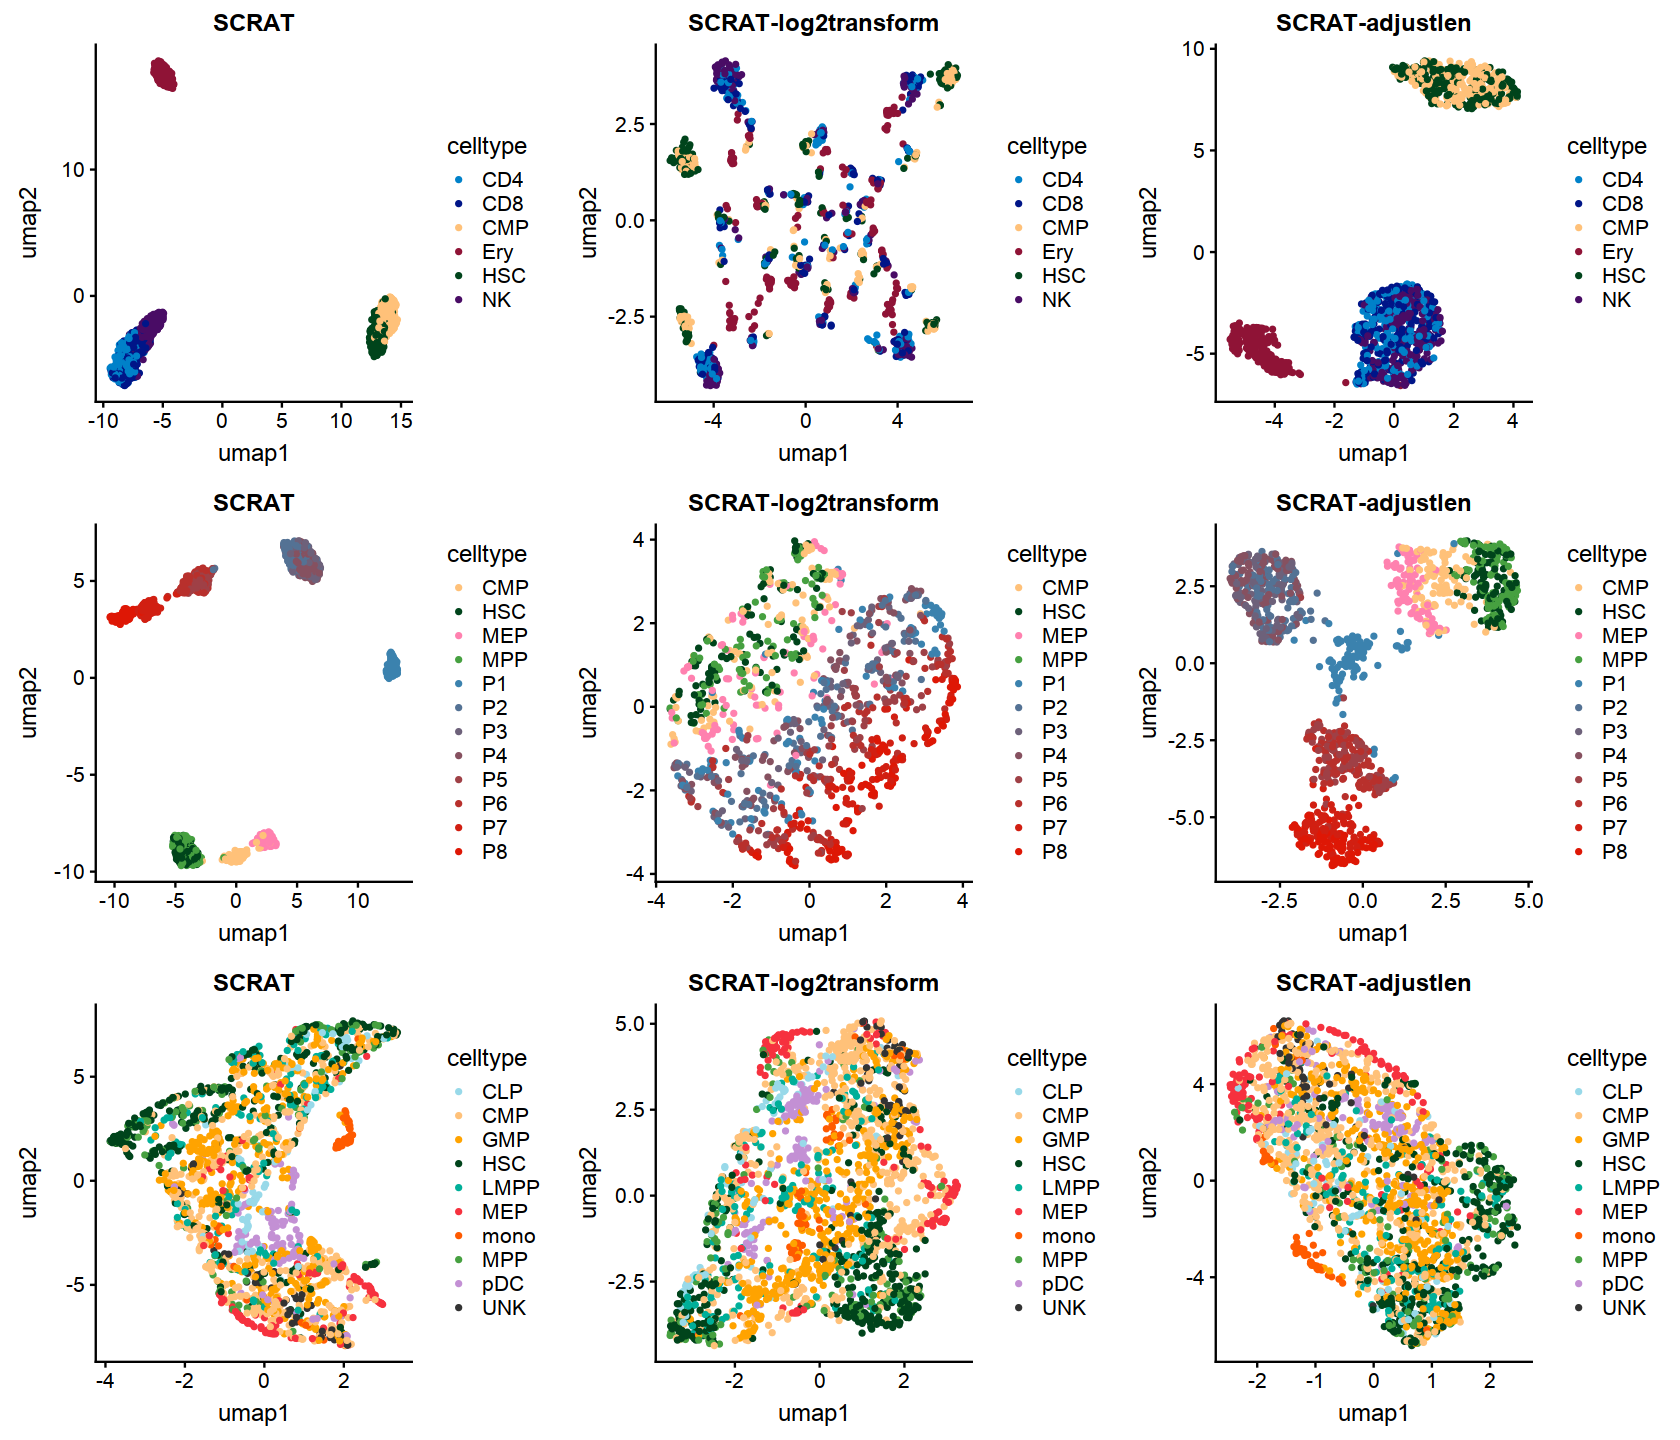

In [3]:
options(repr.plot.width=4*3.5, repr.plot.height=4*3)
p_group = cowplot::plot_grid(
                             p_SCRAT_BM_no, 
                             p_SCRAT_BM_log2transform, 
                             p_SCRAT_BM_adjustlen,     
                             p_SCRAT_Ery_no,
                             p_SCRAT_Ery_log2transform,
                             p_SCRAT_Ery_adjustlen,
                             p_SCRAT_Buenrostro2018_no,
                             p_SCRAT_Buenrostro2018_log2transform,  
                             p_SCRAT_Buenrostro2018_adjustlen,
                             labels = "",
                             align = 'v',ncol = 3)
p_group

In [4]:
cowplot::ggsave(p_group,filename = 'SCRAT_norm_VS_nonorm.pdf', width = 4*3.5, height = 4*3)

In [5]:
save.image(file = 'test_SCRAT_parameters.RData')